In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import InputLayer, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

import time

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Indian_Extent = pd.read_excel(filepath, sheet_name='Indian-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Indian_Extent)
fp.date_time(Indian_Extent)

,Extent,Date
0,376618.799,1979-01-01
1,211788.726,1979-02-01
2,262868.141,1979-03-01
3,698377.304,1979-04-01
4,1252407.727,1979-05-01
...,...,...
533,1520776.003,2023-06-01
534,2076164.165,2023-07-01
535,2731799.027,2023-08-01
536,3179384.692,2023-09-01


In [5]:
scaler = MinMaxScaler()
Indian_Extent['Extent'] = scaler.fit_transform(Indian_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 10
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Indian_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((517, 12, 1), (517,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(Bidirectional(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0))))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Indian_model_LT10/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 26s 328ms/step - loss: 0.2216 - root_mean_squared_error: 0.4707 - val_loss: 0.1204 - val_root_mean_squared_error: 0.3470
Epoch 2/50
53/53 [==============================] - 16s 305ms/step - loss: 0.1097 - root_mean_squared_error: 0.3312 - val_loss: 0.0803 - val_root_mean_squared_error: 0.2833
Epoch 3/50
53/53 [==============================] - 16s 305ms/step - loss: 0.0763 - root_mean_squared_error: 0.2763 - val_loss: 0.0503 - val_root_mean_squared_error: 0.2242
Epoch 4/50
53/53 [==============================] - 17s 322ms/step - loss: 0.0377 - root_mean_squared_error: 0.1943 - val_loss: 0.0147 - val_root_mean_squared_error: 0.1214
Epoch 5/50
53/53 [==============================] - 17s 326ms/step - loss: 0.0178 - root_mean_squared_error: 0.1335 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1158
Epoch 6/50
53/53 [==============================] - 17s 331ms/step - loss: 0.0179 - root_mean_squared_error: 0.1336 - val_loss: 0.0097 

Epoch 33/50
53/53 [==============================] - 3s 54ms/step - loss: 0.0049 - root_mean_squared_error: 0.0700 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0658
Epoch 34/50
53/53 [==============================] - 18s 341ms/step - loss: 0.0052 - root_mean_squared_error: 0.0720 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0511
Epoch 35/50
53/53 [==============================] - 17s 324ms/step - loss: 0.0050 - root_mean_squared_error: 0.0705 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0489
Epoch 36/50
53/53 [==============================] - 17s 335ms/step - loss: 0.0047 - root_mean_squared_error: 0.0689 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0464
Epoch 37/50
53/53 [==============================] - 3s 50ms/step - loss: 0.0048 - root_mean_squared_error: 0.0695 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0556
Epoch 38/50
53/53 [==============================] - 3s 55ms/step - loss: 0.0046 - root_mean_squared_error: 0.0676 - val_loss: 0.0023 

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

7.867069943745931 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

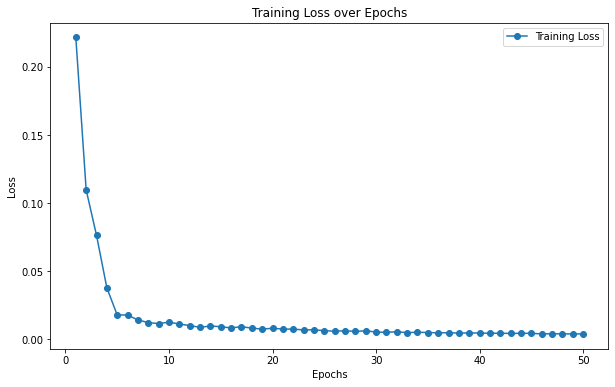

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

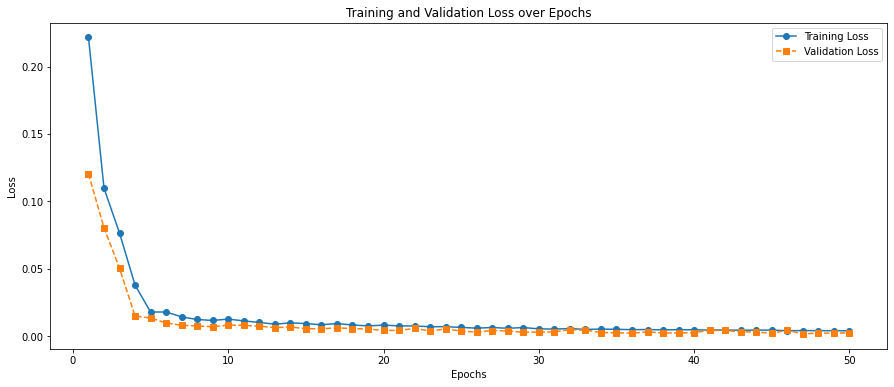

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Indian_model_LT10/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 31ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.04427977992162649
MAE : 0.03697480786617879


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,1.066418e+05,346601.304
1,1.277837e+05,444914.605
2,4.446152e+05,827036.916
3,1.068616e+06,1142021.216
4,1.847275e+06,1885693.654
5,2.452675e+06,2542569.663
6,3.048680e+06,3107373.845
7,3.503627e+06,3488175.444
8,3.459532e+06,3746306.528
9,2.886254e+06,2942322.822


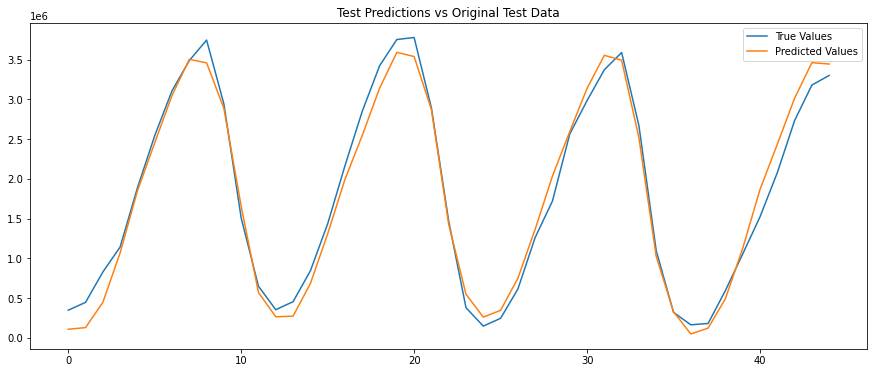

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 1s 34ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

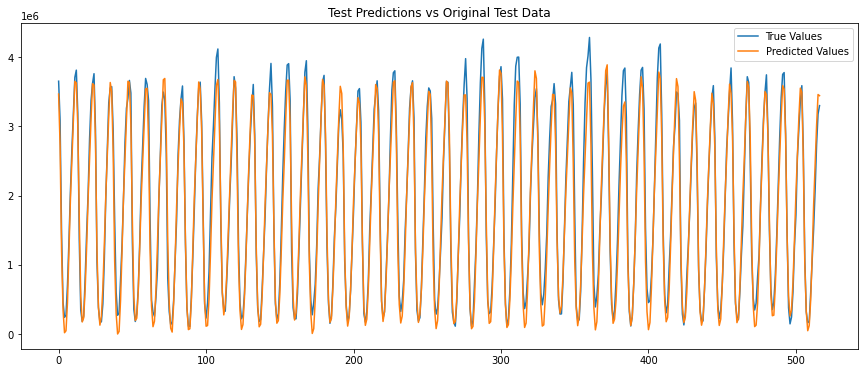

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()